In [1]:
import notebook_setup
from src.config import INTERIM_DATA_DIR
from src.dataset import DatasetAnalyzer, DatasetIO
from src.features_data import FeatureIO, FeatureData

features_path = INTERIM_DATA_DIR / "google_vit_base.pkl"

dt = DatasetIO.load_dataset_pickle(INTERIM_DATA_DIR / "dataset_metadata.pkl")

DatasetAnalyzer.print_dataset_stats(dt)

2025-08-07 11:45:54.313 | INFO     | src.config:<module>:11 - PROJ_ROOT path is: D:\workspace\projects\freelance\3d_recognition_analisis


Project root added to path: d:\workspace\projects\freelance\3d_recognition_analisis
2025-08-07 11:45:54.769 | INFO     | src.dataset:load_dataset_pickle:210 - Загрузка датасета из D:\workspace\projects\freelance\3d_recognition_analisis\data\interim\dataset_metadata.pkl
2025-08-07 11:45:54.807 | SUCCESS  | src.dataset:load_dataset_pickle:215 - Датасет загружен из D:\workspace\projects\freelance\3d_recognition_analisis\data\interim\dataset_metadata.pkl
2025-08-07 11:45:54.807 | INFO     | src.dataset:print_dataset_stats:229 - Статистика по датасету:
2025-08-07 11:45:54.807 | INFO     | src.dataset:print_dataset_stats:230 - Всего 3D моделей: 129
2025-08-07 11:45:54.807 | INFO     | src.dataset:print_dataset_stats:231 - Всего 2D изображений: 1032
2025-08-07 11:45:54.808 | INFO     | src.dataset:print_dataset_stats:232 - Моделей с изображениями: 129
2025-08-07 11:45:54.808 | INFO     | src.dataset:print_dataset_stats:233 - Моделей без изображений: 0
2025-08-07 11:45:54.808 | INFO     | src.

In [ ]:
from transformers import pipeline
import numpy as np
from tqdm.notebook import tqdm


pipe = pipeline(task="image-feature-extraction", model_name="google/vit-base-patch16-384", framework="pt", pool=True)

model_labels = []
model_features = []

for class_model in tqdm(dt):
    raw_features = pipe(class_model.get_images())
    # (n, 768)
    feature_vectors = np.array(raw_features).squeeze(axis=1)

    # усредняем вектор признаков по всем изображениям класса 
    aggregated_feature = np.mean(feature_vectors, axis=0)
    # другой способ max-pooling
    # aggregated_feature = np.max(feature_vectors, axis=0)
    model_features.append(aggregated_feature)
    model_labels.append(class_model.detail_type)

model_features = np.array(model_features)


FeatureIO.save_features(FeatureData(model_labels, model_features), features_path)


In [2]:

feature_data = FeatureIO.load_features(features_path)
FeatureIO.log_feature_info(feature_data)

2025-08-07 11:46:01.420 | SUCCESS  | src.features_data:load_features:30 - Признаки загружены из D:\workspace\projects\freelance\3d_recognition_analisis\data\interim\google_vit_base.pkl
2025-08-07 11:46:01.420 | INFO     | src.features_data:log_feature_info:36 - Количество классов: 12
2025-08-07 11:46:01.420 | INFO     | src.features_data:log_feature_info:37 - Количество признаков: 129
2025-08-07 11:46:01.420 | INFO     | src.features_data:log_feature_info:38 - Размерность признаков: 768


2025-08-07 11:52:06.288 | INFO     | src.plots:plot_similarity_heatmap:36 - График сохранен: D:\workspace\projects\freelance\3d_recognition_analisis\reports\figures\google_vit_base.png


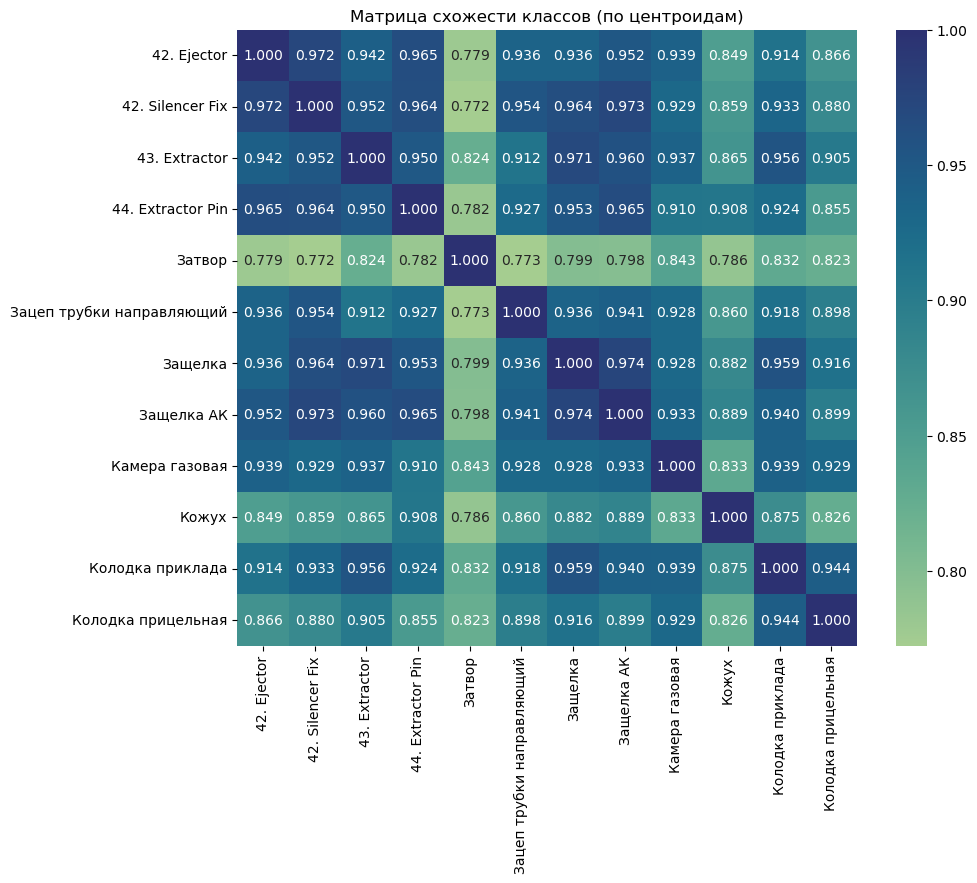

In [5]:
from src.plots import plot_similarity_heatmap

plot_similarity_heatmap(
    feature_data.features,
    feature_data.lables,
    "google_vit_base")

Отчет по классификации:
                           precision    recall  f1-score   support

              42. Ejector       0.83      1.00      0.91         5
         42. Silencer Fix       0.75      1.00      0.86         6
            43. Extractor       1.00      1.00      1.00         6
        44. Extractor Pin       0.80      0.80      0.80         5
                   Затвор       1.00      0.60      0.75         5
Зацеп трубки направляющий       1.00      0.67      0.80         6
                  Защелка       1.00      0.80      0.89         5
               Защелка АК       1.00      1.00      1.00         5
           Камера газовая       1.00      1.00      1.00         5
                    Кожух       1.00      1.00      1.00         6
         Колодка приклада       0.71      1.00      0.83         5
       Колодка прицельная       1.00      1.00      1.00         6

                 accuracy                           0.91        65
                macro avg       0.92

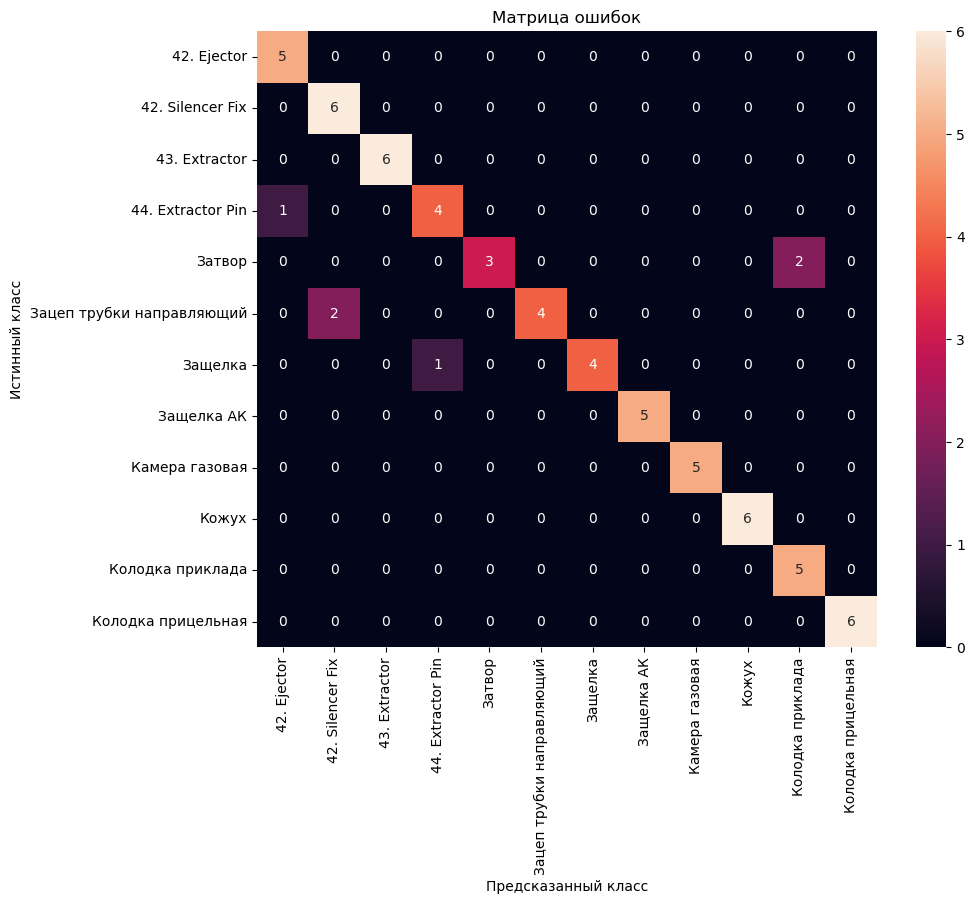

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Разделение данных
X_train, X_test, y_train, y_test = train_test_split(
    model_features, 
    model_labels, 
    test_size=0.5,       # 20% данных на тест
    random_state=42,     # для воспроизводимости результатов
    stratify=model_labels # Важно для сохранения пропорций классов
)

# 2. Обучение модели (например, k-ближайших соседей)
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y_train)

# 3. Получение предсказаний на тестовых данных
y_pred = model.predict(X_test)

# 4. Вывод отчета с основными метриками
print("Отчет по классификации:")
print(classification_report(y_test, y_pred))

# 5. Визуализация матрицы ошибок
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.title('Матрица ошибок')
plt.show()

In [6]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

# Используем все данные, так как cross_val_score сам их разделит
X = model_features
y = np.array(model_labels) # cross_val_score лучше работает с numpy array

# 1. Создаем модель
# Мы можем протестировать несколько значений n_neighbors
for n in [3, 5, 7]:
    model = KNeighborsClassifier(n_neighbors=n)

    # 2. Настраиваем кросс-валидацию
    # StratifiedKFold сохраняет пропорции классов в каждой части (важно для вас)
    # n_splits=5 означает, что у нас будет 5 "прогонов"
    # shuffle=True перемешивает данные перед разделением
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # 3. Запускаем оценку
    # scoring='accuracy' - метрика, которую мы хотим получить
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')

    # 4. Выводим результат
    print(f"--- Результаты для KNeighborsClassifier (n_neighbors={n}) ---")
    print(f"Оценки accuracy для каждой из 5 частей: {np.round(scores, 2)}")
    print(f"Средняя accuracy: {scores.mean():.2f}")
    print(f"Стандартное отклонение: {scores.std():.2f}\n")

--- Результаты для KNeighborsClassifier (n_neighbors=3) ---
Оценки accuracy для каждой из 5 частей: [1.   0.92 0.96 1.   1.  ]
Средняя accuracy: 0.98
Стандартное отклонение: 0.03

--- Результаты для KNeighborsClassifier (n_neighbors=5) ---
Оценки accuracy для каждой из 5 частей: [1.   0.88 0.96 1.   0.92]
Средняя accuracy: 0.95
Стандартное отклонение: 0.05

--- Результаты для KNeighborsClassifier (n_neighbors=7) ---
Оценки accuracy для каждой из 5 частей: [0.92 0.85 0.96 1.   0.92]
Средняя accuracy: 0.93
Стандартное отклонение: 0.05



In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
import numpy as np
import pandas as pd

# Используем те же данные
X = model_features
y = np.array(model_labels)

# 1. Создаем словарь с моделями для тестирования
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Support Vector Machine": SVC(),
    "Random Forest": RandomForestClassifier(random_state=42)
}

# 2. Настраиваем кросс-валидацию
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 3. Запускаем оценку для каждой модели и сохраняем результаты
results = []
for name, model in models.items():
    # Используем 'f1_weighted' для более надежной оценки на несбалансированных данных
    scores = cross_val_score(model, X, y, cv=cv, scoring='f1_weighted')
    results.append({
        "model": name,
        "mean_f1_score": scores.mean(),
        "std_f1_score": scores.std()
    })

# 4. Выводим результаты в виде удобной таблицы
results_df = pd.DataFrame(results)
print("Сравнение производительности моделей:")
print(results_df.sort_values(by="mean_f1_score", ascending=False))

Сравнение производительности моделей:
                    model  mean_f1_score  std_f1_score
0     Logistic Regression       1.000000      0.000000
3           Random Forest       0.991795      0.016410
1     K-Nearest Neighbors       0.948135      0.051371
2  Support Vector Machine       0.865150      0.049629


In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Используем те же данные
X = model_features
y = np.array(model_labels)

# 1. Определяем модель, которую будем настраивать
model = RandomForestClassifier(random_state=42)

# 2. Задаем "сетку" параметров для перебора
#    n_estimators: количество деревьев в "лесу"
#    max_depth: максимальная глубина каждого дерева
#    min_samples_leaf: минимальное количество примеров в "листе" дерева
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_leaf': [1, 2, 4]
}

# 3. Настраиваем поиск с кросс-валидацией
#    cv=5: используем 5-кратную кросс-валидацию
#    scoring='f1_weighted': наша целевая метрика
#    n_jobs=-1: использовать все доступные ядра процессора для ускорения
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                           cv=cv, n_jobs=-1, scoring='f1_weighted', verbose=2)

# 4. Запускаем поиск
grid_search.fit(X, y)

# 5. Выводим лучшие найденные параметры и лучший результат
print("\nЛучшие параметры, найденные GridSearchCV:")
print(grid_search.best_params_)

print(f"\nЛучшая средняя f1_weighted оценка на кросс-валидации: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 27 candidates, totalling 135 fits

Лучшие параметры, найденные GridSearchCV:
{'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 50}

Лучшая средняя f1_weighted оценка на кросс-валидации: 1.0000


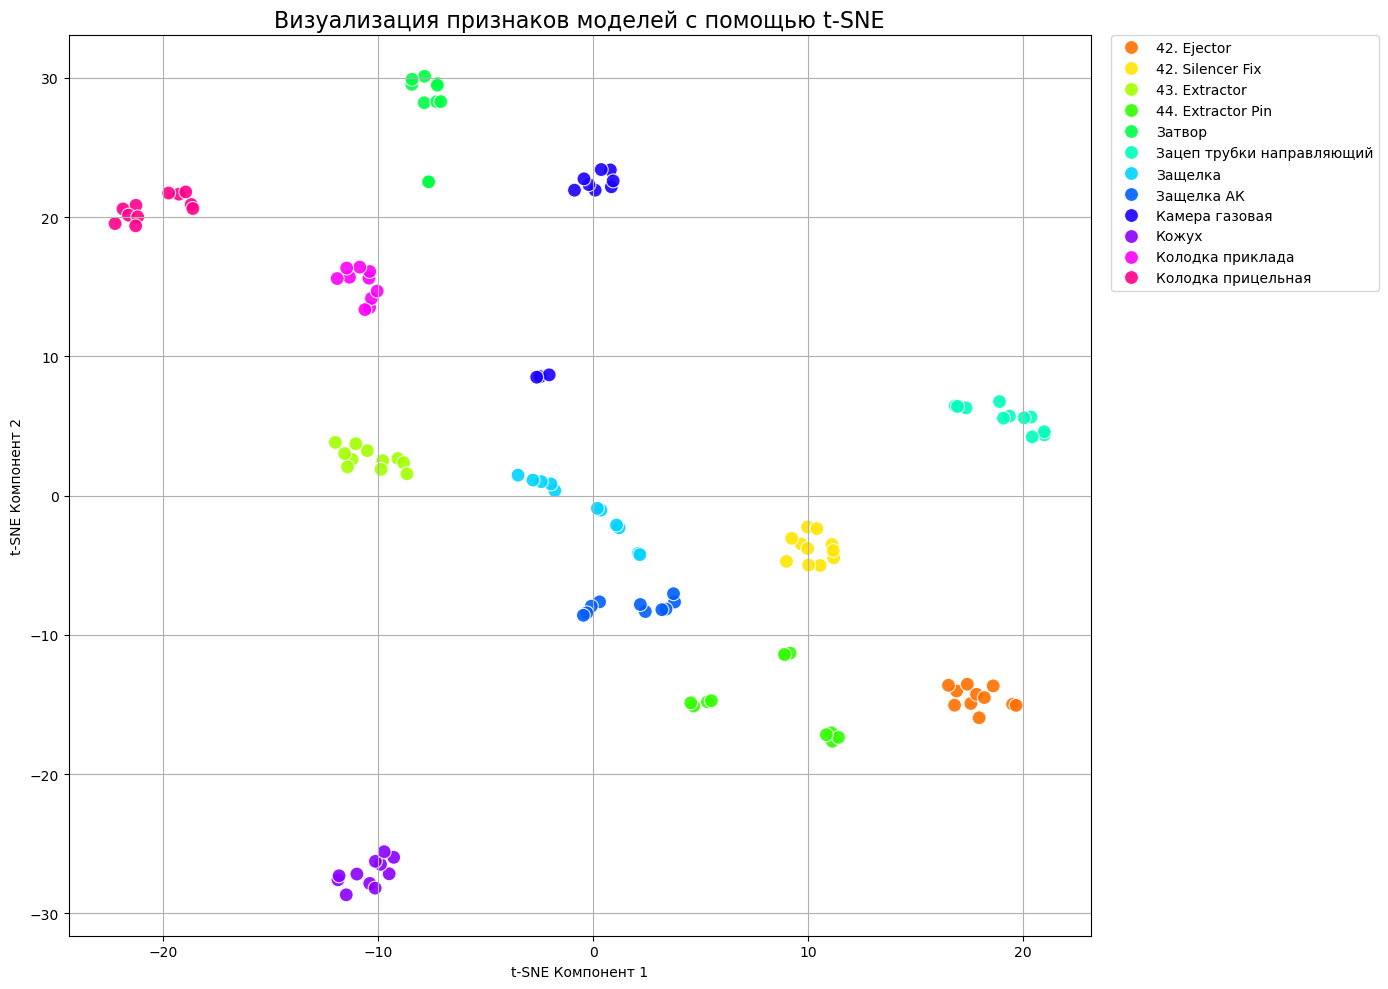

In [10]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Инициализация t-SNE
# perplexity - это параметр, связанный с количеством ближайших соседей для каждой точки.
# Обычно его выбирают в диапазоне от 5 до 50. Для небольших датасетов лучше брать меньшее значение.
# n_iter - количество итераций для оптимизации.
tsne = TSNE(n_components=2, perplexity=10, random_state=42, max_iter=1000)

# 2. Применяем t-SNE к нашим признакам
tsne_features = tsne.fit_transform(model_features)

# 3. Создаем DataFrame для удобной визуализации
df_tsne = pd.DataFrame({
    'tsne_1': tsne_features[:, 0],
    'tsne_2': tsne_features[:, 1],
    'label': model_labels
})

# 4. Строим график
plt.figure(figsize=(14, 10))
sns.scatterplot(
    x="tsne_1", y="tsne_2",
    hue="label",
    palette=sns.color_palette("hsv", len(df_tsne['label'].unique())),
    data=df_tsne,
    legend="full",
    alpha=0.9,
    s=100 # Размер точек
)

plt.title('Визуализация признаков моделей с помощью t-SNE', fontsize=16)
plt.xlabel('t-SNE Компонент 1')
plt.ylabel('t-SNE Компонент 2')

# Выносим легенду за пределы графика, чтобы она не мешала
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.grid(True)
plt.tight_layout() # Автоматически подгоняет размеры, чтобы все поместилось
plt.show()

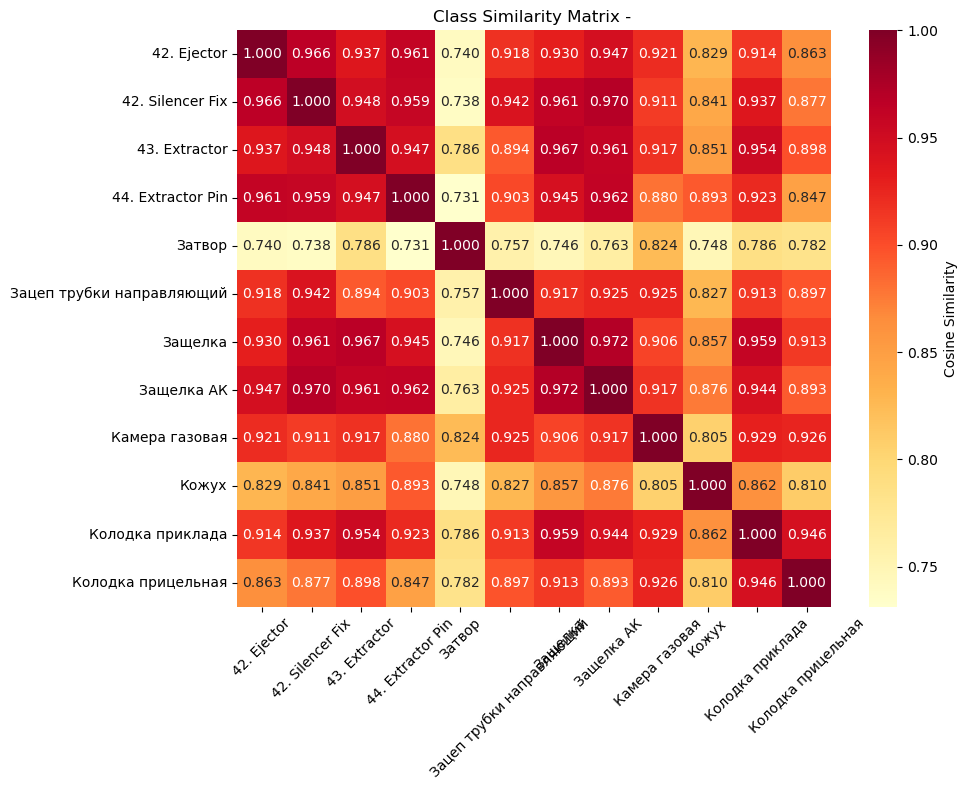

In [18]:
from src.plots import plot_similarity_heatmap

plot_similarity_heatmap(model_features, model_labels, save=False)